# Libraries

In [1]:
# To work dith data
import pandas as pd
import numpy as np
import glob
# Quality metrics
from sklearn.metrics import r2_score, mean_absolute_percentage_error
# Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import matplotlib.dates as md
import seaborn as sns
# Track progress
from tqdm.notebook import tqdm,trange
from tqdm.keras import TqdmCallback
# Tensorflow
import tensorflow
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense, concatenate, Dropout, LSTM
# PyTorch
import torch
import torch.nn as nn

# Modules
import preprocessing
import micro_model_functions
import micro_help_functions
import macro_model_functions
import macro_help_functions

# Loading data

In [2]:
df = pd.read_csv('transact_18_22.csv')

print('df shape: ', df.shape)
df.head()

df shape:  (19262668, 7)


,client,card,date,amt,mcc,group,value
0,390989,3048567,2018-01-01,878.0,5814,food,survival
1,1309946,3226559,2018-01-01,249.0,5411,food,survival
2,1386278,2715990,2018-01-01,50.0,5499,food,survival
3,475694,2884069,2018-01-01,2564.0,5941,fun,self_realization
4,710293,3396065,2018-01-01,464.9,5814,food,survival


If MCCs are not grouped yet:

In [3]:
# to 14 groups of client interests
df = preprocessing.cats_to_14(df=df, col='mcc', new_col='group')

# to 3 groups of basic values
# won't take 'money' group into consideration
df = df[~df['group'].isin(['money'])]
# "client interest":"base value"
cats_3_dict = {'food':'survival', 'outfit':'survival', 'dwelling':'survival', 'health':'survival',
     'remote':'socialization','travel':'socialization','nonfood':'socialization','telecom':'socialization','misc':'socialization',
     'beauty':'self_realization', 'kids':'self_realization','fun':'self_realization', 'charity':'self_realization'}
df['value'] = df['group'].apply(lambda x: cats_3_dict[x])

In [4]:
# just in case there're more than 3 base values
df = df[df['value'].isin(['survival','socialization','self_realization'])]
df.amt = df.amt.astype('int')

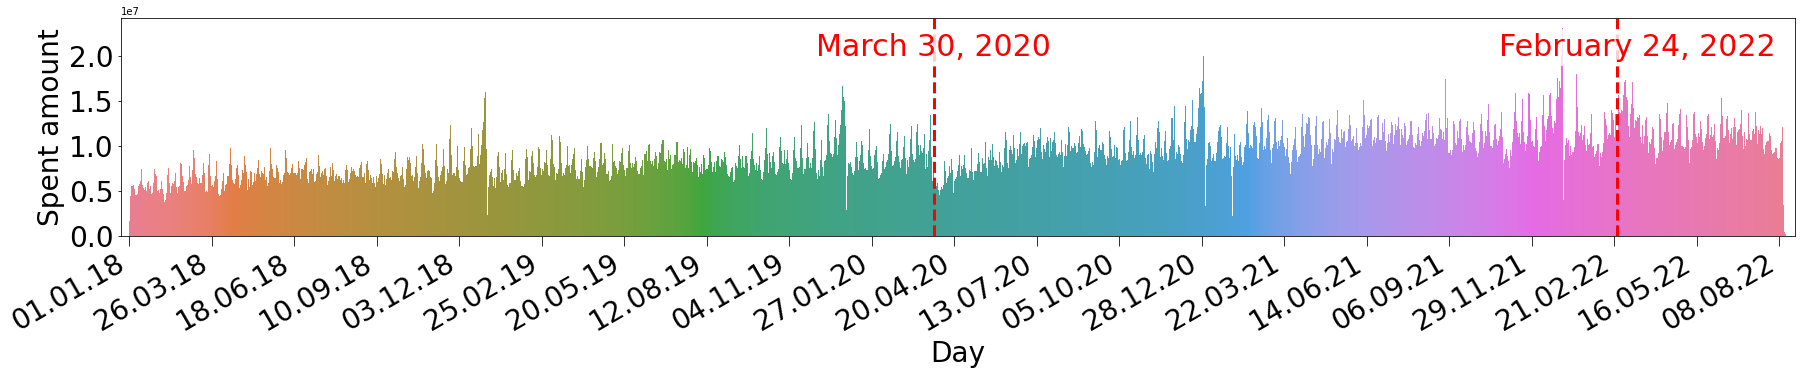

In [6]:
fig, ax = plt.subplots(figsize = (30, 4))
font_size = 28

# the position of the major ticks at the beginning of the week
ax.xaxis.set_major_formatter(md.DateFormatter('%d.%m.%y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

# total spent amount for all clients
grouped = df.sort_values(by = 'date').groupby('date')['amt'].sum().reset_index(name='amt')
# all days
dates = pd.Series(pd.date_range(df.date.min(),df.date.max())).dt.strftime('%d.%m.%y')

plot = plt.bar(grouped.date, grouped.amt, 
               color=sns.color_palette('husl',len(grouped.date),desat=0.8), width=1);

ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1, interval=2))

# ticks length
ax.tick_params(axis = 'x', which = 'major', length = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5)

plt.xlabel('Day', fontsize=font_size)
plt.ylabel('Spent amount', fontsize=font_size)
plt.margins(x=0.005)
plt.xticks(grouped.date[::84], dates[::84], rotation=30, ha='right', fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.axvline(dates[dates=='30.03.20'].index[0], ls='--', lw=3, color='red')
plt.text(dates[dates=='30.03.20'].index[0]-120, 20000000,'March 30, 2020',
         c='red', fontsize=font_size+2, bbox = dict(facecolor='white', alpha=0.8, linewidth=0))
plt.axvline(dates[dates=='24.02.22'].index[0], ls='--', lw=3, color='red')
plt.text(dates[dates=='24.02.22'].index[0]-120, 20000000,'February 24, 2022',
         c='red', fontsize=font_size+2, bbox = dict(facecolor='white', alpha=0.8, linewidth=0))

plt.show();

Choosing 3 000 clients with the highest number of transactions through the whole time period

In [13]:
df = df[df.client.isin(df.client.value_counts().iloc[:3000].index)]
df.shape

(8265305, 7)

# Preprocessing

## Dataframe: whether there were transactions, total spent amount

In [15]:
bin_compressed = preprocessing.create_trans_data(df=df, col_clientid='client', 
                                                 col_date='date', col_group='value', col_amount='amt')
bin_compressed.head()

,bin_trans,money_trans
2005,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,...","[[0, 8145, 0, 0, 0, 0, 0, 0, 0, 251, 0, 0, 632..."
2213,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0..."
3427,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5044,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1810,..."
5112,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [16]:
# Saving to get real clients' ids and their spent amounts later
bin_compressed.to_pickle('1822_real_id_bin_money.pkl')

## Adding data features

Encoding time features with sine/cosine transformation

In [17]:
feat_df = preprocessing.add_date_features(start_date=df.date.min(), end_date=df.date.max(),
                                          main_feat_trans=bin_compressed['bin_trans'])
feat_df

0       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [1.0, 0....
1       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
3       [[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
4       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
                              ...                        
2995    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2996    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2997    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2998    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2999    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
Length: 3000, dtype: object

Each day is described by 7 features: whether there were transactions in the self-realization group, in the socialization group, in the survival group, sine of a day of the week, corresponding cosine, sine of a month, corresponding cosine

In [18]:
feat_df.iloc[0].shape

(1688, 7)

In [59]:
# saving
feat_df.to_pickle("1822_3000_amnt_binclass.pkl", protocol=4)

# Micro-level forecasting

## TrainTest split

The training set consists of a year’s worth of days  from January 1, 2018 to December 31, 2018

The validation one has days from January 1, 2019 to July 15, 2019.

In [22]:
days_in_train=365
train_df = feat_df.apply(lambda x: x[ : days_in_train])
test_df = feat_df.apply(lambda x: x[days_in_train : 561])

In [23]:
# clients will be forecasted in the same order
np.random.seed(42)
clients = list(feat_df.index)
clients[:5]

[0, 1, 2, 3, 4]

## Forecasting for each client and each base value

In [102]:
client_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# For each client
for client_id in tqdm(clients[2:3], desc='clients'):
    b_cats_r = []
    i_cats_r = []
    
    # Get client's data
    all_x,all_y,all_test_x,all_test_y = micro_help_functions.get_splits_by_client(client_id, train_df, test_df)
    
    # For each base value (CATegory)
    for cat in range(3):
        
        # Training a base model
        cl_model, cl_optimizer, train_losses, test_losses, \
            cl_checkpoint, weights = micro_model_functions.train_model(all_x,all_y,
                                                                       all_test_x,all_test_y, 
                                                                       e_n=1000, lr=0.0005,cat=cat)
        
        # Saving the base model
        torch.save(cl_checkpoint, f'model_{cat}.pth')
        model_after = micro_model_functions.LSTM_cat_model(input_size=5, hidden_size=64, to_pred=7).to(device)
        checkpoint = torch.load(f'./model_{cat}.pth')
        model_after.load_state_dict(checkpoint['model'])
        
        # Test data as weeks
        days = pd.date_range('2019-01-01','2022-08-08')
        days = np.array(days).reshape(-1,7).astype('datetime64[D]')
        # Client's data but with date for target days
        q = micro_help_functions.get_df_full_y_new(feat_df.loc[client_id][365-28:], 
                                                   min_date='2018-12-04', max_date='2022-08-15')[::7]

        # The base model's forecasts
        b_r = micro_model_functions.base_model_data(q,model_after,days,cat=cat)
        b_cats_r.append(b_r)

        # Loading the saved base model
        the_checkpoint = torch.load(f'./model_{cat}.pth')
        imodel_after = micro_model_functions.LSTM_cat_model(input_size=5, hidden_size=64, to_pred=7).to(device)
        imodel_after.load_state_dict(the_checkpoint['model'])
        ioptimizer_after = torch.optim.Adam(params=filter(lambda p: p.requires_grad, imodel_after.parameters()),
                                            lr=0.0005)
        ioptimizer_after.load_state_dict(the_checkpoint['optimizer'])
        # Changing learning rate
        for param_group in ioptimizer_after.param_groups:
            param_group['lr'] = 0.0001
        
        # The incremental model's forecasts
        i_r = micro_model_functions.incr_model_data(q, imodel_after,days,ioptimizer_after, 
                                                    with_weights=False,cat=cat)
        i_cats_r.append(i_r)
    
    # Saving both real values and predictions for the base and incremental models
    client_dict[client_id] = [b_cats_r,i_cats_r]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [103]:
# Saving
df_2models = pd.DataFrame.from_dict(client_dict).T
#df_2models.to_pickle('/content/drive/MyDrive/master/2nd/the_project/2700-3000_yt_yp_RIGHTV.pkl')
df_2models.columns = [['base','inc']]
df_2models

,base,inc
2,"[[[[0. 0. 0. 0. 0. 0. 0.], [0.541454 0.48680...","[[[[0. 0. 0. 0. 0. 0. 0.], [[0.54145396 0.4868..."


## Comparing base and incremental models

In [7]:
path_to_2models_data_folder = 'client_data_001_testfrom19/' # folder with .pkl files

# Loading real values and predictions for the base and incremental models
df_2models = pd.concat(map(pd.read_pickle, glob.glob(path_to_2models_data_folder+'*.pkl')))
df_2models = df_2models[~df_2models.index.duplicated(keep='first')].sort_index()
df_2models.columns = [['base','inc']]

print(df_2models.shape)
df_2models.head()

(3000, 2)


,base,inc
0,"[[[[0. 1. 0. 1. 0. 0. 1.], [-1.182159 -1.289...","[[[[0. 1. 0. 1. 0. 0. 1.], [[-1.1821591 -1.28..."
1,"[[[[0. 1. 0. 0. 0. 0. 0.], [1.034886 1.173865...","[[[[0. 1. 0. 0. 0. 0. 0.], [[1.0348861 1.17386..."
2,"[[[[0. 0. 0. 0. 0. 0. 0.], [-0.10904915 0.006...","[[[[0. 0. 0. 0. 0. 0. 0.], [[-0.10904916 0.00..."
3,"[[[[0. 0. 0. 0. 0. 1. 0.], [0.18922582 0.62491...","[[[[0. 0. 0. 0. 0. 1. 0.], [[0.18922582 0.6249..."
4,"[[[[1. 0. 0. 0. 0. 0. 0.], [1.3155253 1.522739...","[[[[1. 0. 0. 0. 0. 0. 0.], [[1.315525 1.52273..."


In [8]:
# Calculating metric for each base value and the aggregated metric
inc_with_metric, inc_with_metric_3in1, base_with_metric, \
base_with_metric_3in1 = micro_help_functions.get_base_inc_arrays(df_2models, 
                                                                 micro_help_functions.F1metr, n_test_weeks=188)

C:\Users\user\anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Two models' forecasts on all remaining weeks

In [16]:
import matplotlib

font_size = 33
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

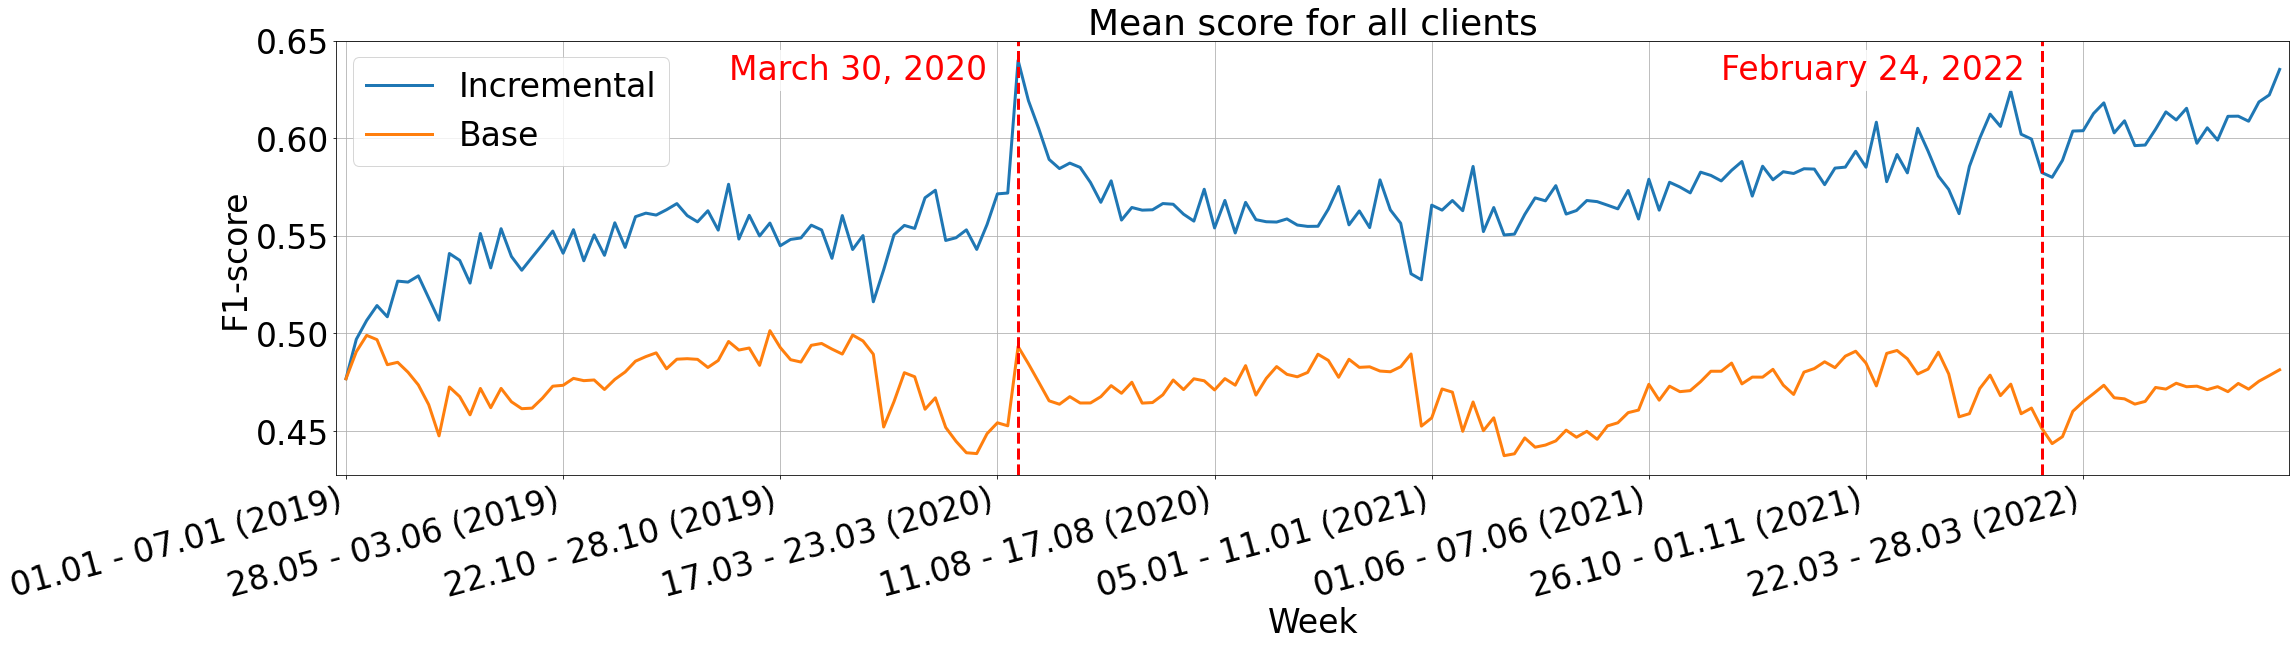

In [10]:
plt.rcParams['figure.figsize'] = 35, 8

days_test = pd.date_range('2019-01-01','2022-08-08')
days_test = np.array(days_test).reshape(-1,7).astype('datetime64[D]')
a0 = pd.Series(days_test[:,0]).dt.strftime('%d.%m')
a1 = pd.Series(days_test[:,-1]).dt.strftime('%d.%m (%Y)')

plt.plot(a0+' - '+a1, np.mean(inc_with_metric_3in1,0),
         '-',c=cmap.colors[0],label='Incremental',linewidth=3)
plt.plot(a0+' - '+a1, np.mean(base_with_metric_3in1,0),
         '-',c=cmap.colors[1],label='Base',linewidth=3)

plt.xticks((a0+' - '+a1)[::21], rotation=15, ha='right')

plt.axvline(65, ls='--', lw=3, color='red')
plt.text(67-30,0.63,'March 30, 2020',c='red', fontsize=font_size, 
         bbox = dict(facecolor='white', alpha=0.8, linewidth=0))
plt.axvline(164, ls='--', lw=3, color='red')
plt.text(166-33,0.63,'February 24, 2022',c='red', fontsize=font_size, 
         bbox = dict(facecolor='white', alpha=0.8, linewidth=0))

plt.grid()
plt.legend()
plt.margins(x=0.005)

plt.xlabel('Week')
plt.ylabel('F1-score')
plt.title('Mean score for all clients',fontsize=font_size+3);

In [11]:
# mean difference in metric before March 30, 2020
np.mean(np.mean(inc_with_metric_3in1[:,:65],0) - np.mean(base_with_metric_3in1[:,:65],0))

0.06857313276467887

In [12]:
# mean difference in metric after March 30, 2020
np.mean(np.mean(inc_with_metric_3in1[:,65:],0) - np.mean(base_with_metric_3in1[:,65:],0))

0.10998765106226814

In [13]:
# mean difference in metric
np.mean(inc_with_metric_3in1[:,-1],0) - np.mean(base_with_metric_3in1[:,-1],0)

0.15391814585883123

# Meso- and macro-level forecasting

## Client segmentation based on predictability

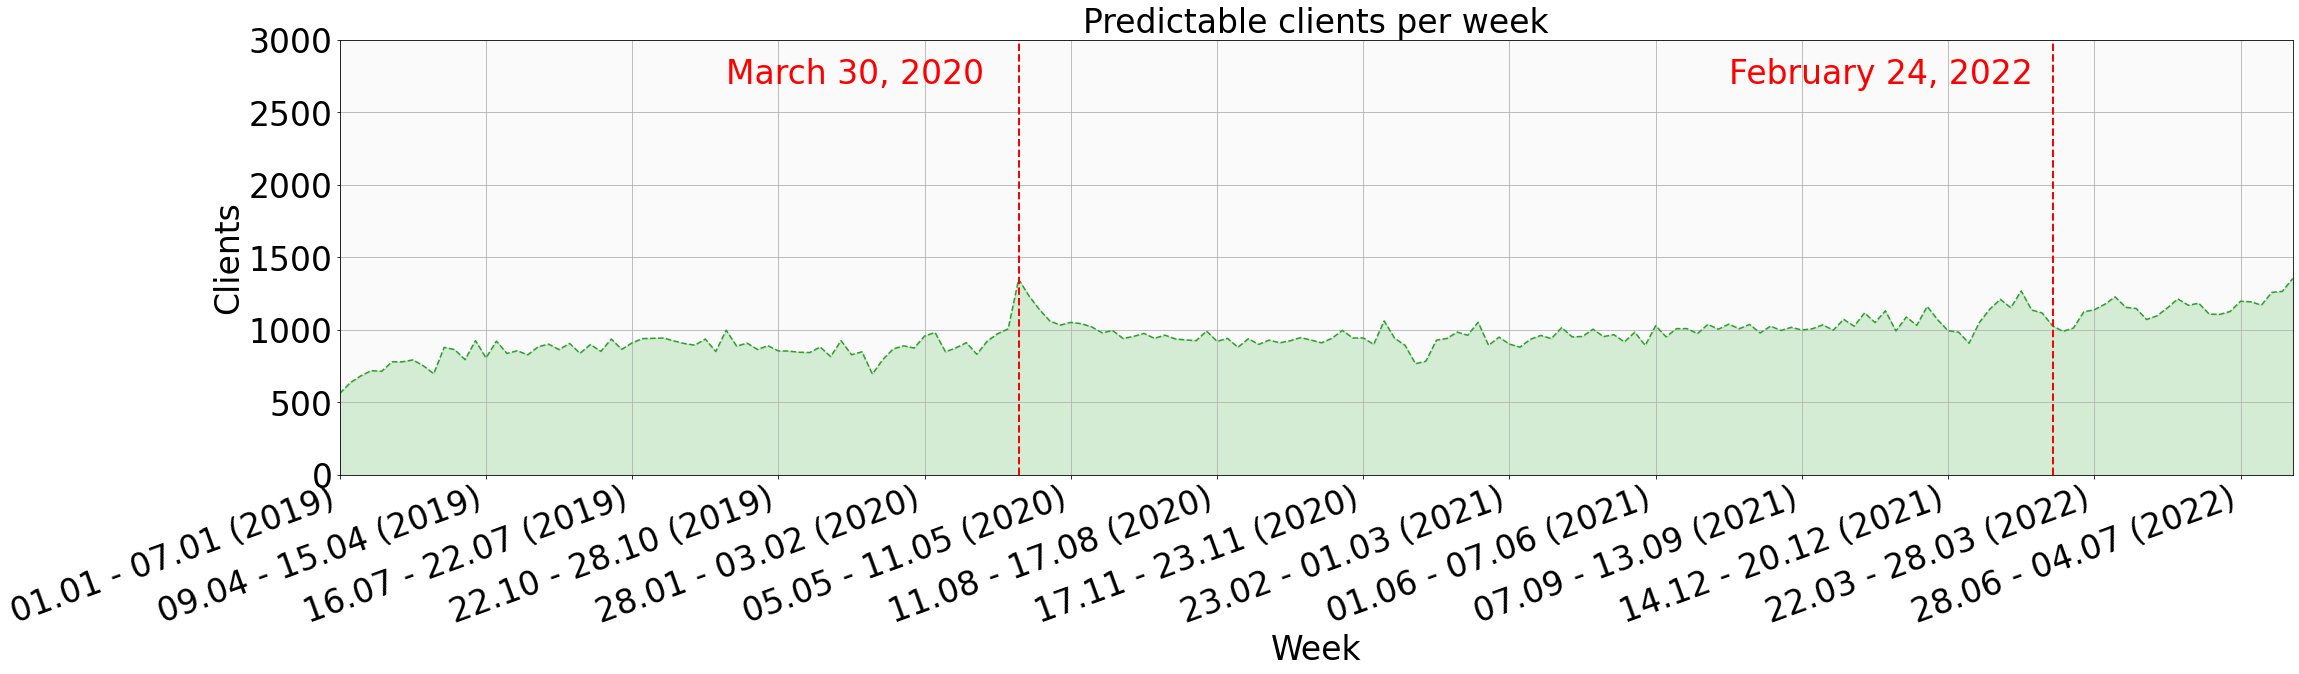

In [17]:
plt.rcParams['figure.figsize'] = 35, 8
# clients' binary predictability for every week
threshold = 0.7
bool_clients = np.array([[int(x_week>threshold) for x_week in user] for user in inc_with_metric_3in1])

plt.plot((a0+' - '+a1), bool_clients.sum(0),'--',color=cmap.colors[2])
plt.fill_between((a0+' - '+a1),bool_clients.sum(0), 0, color=cmap.colors[2], alpha=0.2)
plt.fill_between((a0+' - '+a1),3000, bool_clients.sum(0), color='gray', alpha=0.04)

plt.ylim(0,3000)
plt.margins(x=0)

plt.axvline(65, ls='--', lw=2, color='red')
plt.text(67-30,2700,'March 30, 2020',c='red')
plt.axvline(164, ls='--', lw=2, color='red')
plt.text(166-33,2700,'February 24, 2022',c='red')

plt.xticks((a0+' - '+a1)[::14], rotation=20, ha='right')

plt.title('Predictable clients per week')
plt.grid()
plt.ylabel('Clients')
plt.xlabel('Week');

In [19]:
# Loading data with clients' real ids and spent amounts
df_real_id = pd.read_pickle('1822_real_id_bin_money.pkl')
df_real_id.head()

,bin_trans,money_trans
2005,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,...","[[0, 8145, 0, 0, 0, 0, 0, 0, 0, 251, 0, 0, 632..."
2213,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0..."
3427,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5044,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1810,..."
5112,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


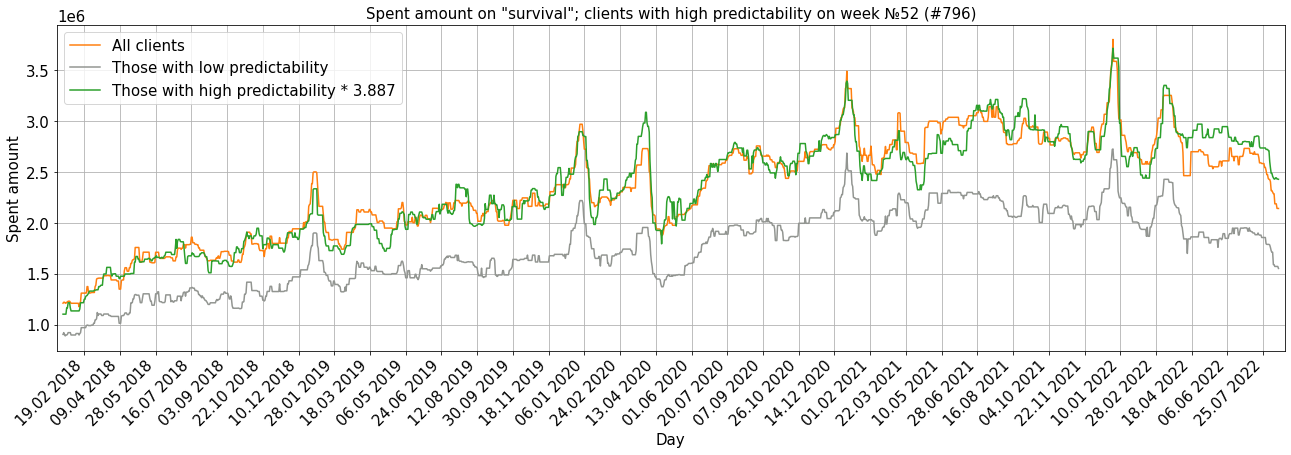

In [21]:
nth_week=52
# finding spent amount for each client class on a given week
good_clients_id, good_rw, \
bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)


font_size = 15
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title


dates = pd.Series(pd.date_range('2018-01-01','2022-08-15')).dt.strftime('%d.%m %Y')
fig = plt.figure(figsize=(22, 6))

plt.plot(dates, all_rw, '-', c=cmap.colors[1], label='All clients')
plt.plot(dates, bad_rw, '-', c='xkcd:gray',label='Those with low predictability')
coeff_good = all_rw.mean()/good_rw.mean()
plt.plot(dates, good_rw*coeff_good, '-',c=cmap.colors[2],label=f'Those with high predictability * {coeff_good:.3f}',lw=1.5)

plt.title(f'Spent amount on "survival"; clients with high predictability on week №{nth_week} (#{good_clients_id.shape[0]})')
plt.xlabel('Day')
plt.ylabel('Spent amount')

plt.grid()
plt.xticks(dates[::49], rotation=45, ha='right')
plt.margins(x=0.005)
plt.legend();

## Forecasting; forecast quality for the same predictability class

Predicting 7 days one at a time

### Preparations

In [23]:
# dates 
n_weeks=136
days_test2 = pd.date_range('2020-01-01','2022-08-09')
days_test2 = np.array(days_test2).reshape(-1,7).astype('datetime64[D]')
a0_md = pd.Series(days_test2[:,0]).dt.strftime('%m.%d')
a1_md = pd.Series(days_test2[:,-1]).dt.strftime('%m.%d')
a0_dm = pd.Series(days_test2[:,0]).dt.strftime('%d.%m.%Y')
a1_dm = pd.Series(days_test2[:,-1]).dt.strftime('%d.%m.%Y')

# clients' classes on the first week
nth_week = 0
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,
                                                                                       df_real_id,bool_clients,
                                                                                       nth_week,window_size=21)

In [26]:
days = pd.date_range('2018.01.01',f'2022.08.15')
days = pd.Series(days).dt.strftime('%d.%m.%Y')
last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
shift_days = good_rw.first_valid_index() 

# Hyperparameters
dim=28 # forecast based on <dim> previous days
mem=5 # LSTM memory 
split= days.shape[0]-last_day-1 # train test split (from the end)
fwd = 7 # how many days to forecast (one by one)
n_epochs_each_model = 10
n_batch_each_model = 1
lr_each_model = 0.00005
n_neurons_each_model = 50

### Class of clients with high predictability

In [27]:
# Preprocessing: data to [-1,1]
scaler, x, y, dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], split, dim, mem)
# Training the model
model, fwd_mapes, full_fwd_pred_tr, \
    full_fwd_true, y_pred_tr, y_true = macro_model_functions.make_model(scaler, x, y, dat, good_rw.iloc[shift_days:],
                                                                        dim, mem, split, fwd, \
                                                                        n_epochs_each_model, n_batch_each_model,
                                                                        n_neurons_each_model,lr_each_model)

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

In [33]:
# Forecasting on test

next_fwd_mapes = fwd_mapes.copy()
next_full_fwd_pred_tr = full_fwd_pred_tr.copy()
next_full_fwd_true = full_fwd_true.copy()

# For each week
for nth_week in trange(1,n_weeks-1):
    # finding class clients on this week
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    # from what day to forecast
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    # forecasting
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_good_rw.iloc[shift_days:], next_split, dim, mem, 0)
    next_fwd_mapes, next_full_fwd_pred_tr, next_full_fwd_true = macro_model_functions.make_pred_base_model(model, next_scaler, next_dat, next_good_rw,
                            dim, mem, next_split, fwd,
                            next_fwd_mapes, next_full_fwd_pred_tr, next_full_fwd_true)

  0%|          | 0/134 [00:00<?, ?it/s]

Visualizing predictions

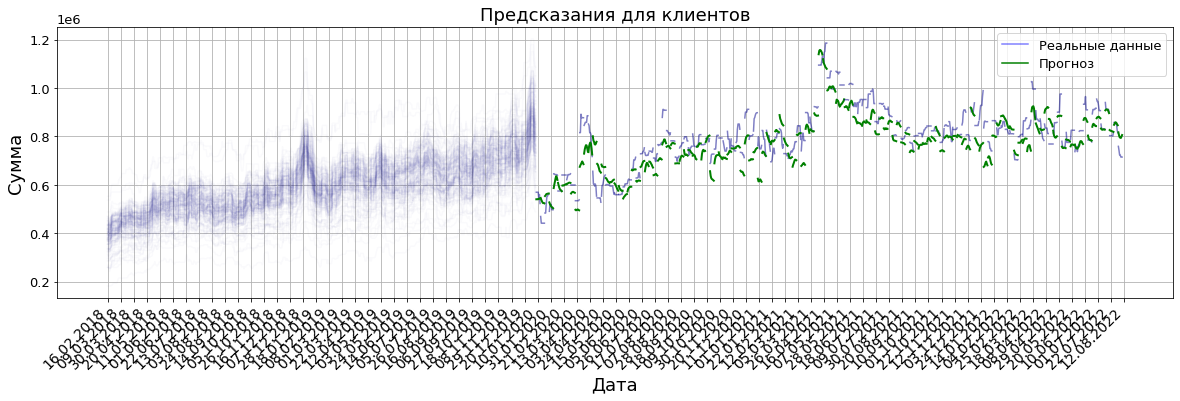

In [35]:
r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr, next_full_fwd_true,split,
                                                dim, mem, fwd, days, tick_freq=21,n_weeks=n_weeks)

line1 = Line2D([0], [0], label='Real data', color='blue', alpha=0.5)
line2 = Line2D([0], [0], label='Forecast', color='green')
plt.legend(handles=[line1, line2], loc='upper right', fontsize=13);

HP(Hit Probability): fraction of MAPE values, which are lower than 5%

In [36]:
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes)<=0.05)[0].shape[0] / np.array(next_fwd_mapes).shape[0]) * 100 :.3f}%')

test MAPE median: 5.739%
test MAPE HP: 42.222%


#### Finding clients in a given class once (on week 52)

In [37]:
nth_week = 52
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)


In [38]:
# Preprocessing: data to [-1,1]
scaler, x, y, dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], split, dim, mem)
# Training the model
model, fwd_mapes, full_fwd_pred_tr, \
    full_fwd_true, y_pred_tr, y_true = macro_model_functions.make_model(scaler, x, y, dat, good_rw.iloc[shift_days:],
                                                                        dim, mem, split, fwd, \
                                                                        n_epochs_each_model, n_batch_each_model,
                                                                        n_neurons_each_model,lr_each_model)   


0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

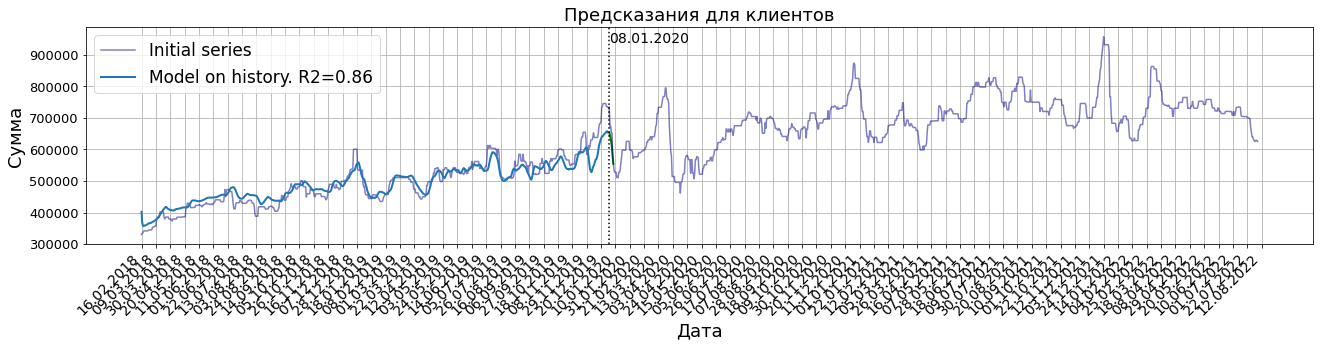

In [39]:
plt.rcParams['figure.figsize'] = 22, 4
r = macro_help_functions.plot_clients_pred(good_rw.iloc[shift_days:], full_fwd_pred_tr,full_fwd_true,y_true,y_pred_tr,
        dim, mem, split, fwd, days, tick_freq=21)

In [40]:
next_fwd_mapes_1t = fwd_mapes.copy()
next_full_fwd_pred_tr_1t = full_fwd_pred_tr.copy()
next_full_fwd_true_1t = full_fwd_true.copy()

# For each week
for nth_week in trange(1,n_weeks-1):
    # Day, from which to start forecasting
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    # Forecasting
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], next_split, dim, mem, 0)
    next_fwd_mapes_1t, next_full_fwd_pred_tr_1t, next_full_fwd_true_1t = macro_model_functions.make_pred_base_model(model, next_scaler, next_dat, good_rw,
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_1t, next_full_fwd_pred_tr_1t, next_full_fwd_true_1t)

  0%|          | 0/134 [00:00<?, ?it/s]

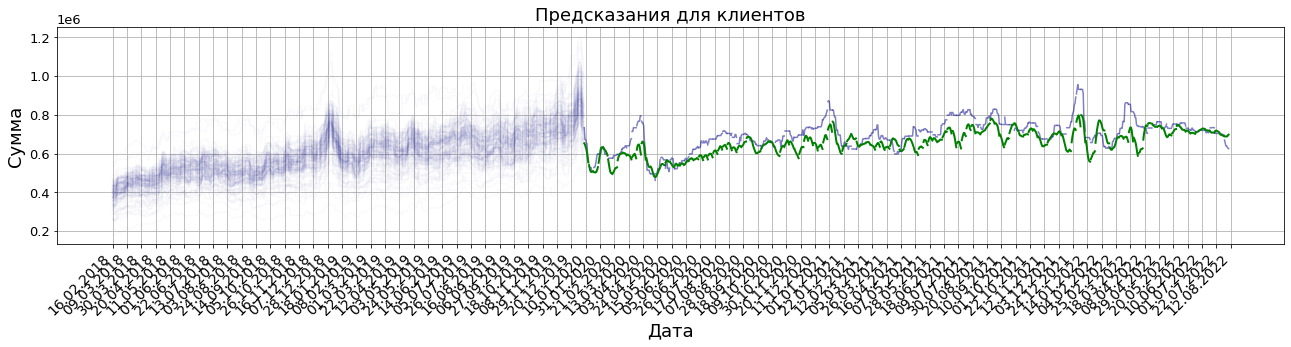

In [41]:
plt.rcParams['figure.figsize'] = 22, 4
r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_1t, next_full_fwd_true_1t,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [42]:
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_1t)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_1t).shape[0]) * 100 :.3f}%')

test MAPE median: 5.530%
test MAPE HP: 39.259%


### All clients

In [43]:
nth_week = 0
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
scaler_all, x_all, y_all, dat_all = macro_help_functions.prepare_data(all_rw.iloc[shift_days:], split, dim, mem)

model_all, fwd_mapes_all, full_fwd_pred_tr_all, full_fwd_true_all, \
                    y_pred_tr_all, y_true_all = macro_model_functions.make_model(scaler_all, x_all, y_all, dat_all, all_rw.iloc[shift_days:],
                                                                                dim, mem, split, fwd, \
                                                                                n_epochs_each_model, n_batch_each_model,n_neurons_each_model,lr_each_model)

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

In [44]:
next_fwd_mapes_all = fwd_mapes_all.copy()
next_full_fwd_pred_tr_all = full_fwd_pred_tr_all.copy()
next_full_fwd_true_all = full_fwd_true_all.copy()
good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week=0,window_size=21)

for nth_week in trange(1,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_all_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    next_fwd_mapes_all, next_full_fwd_pred_tr_all, next_full_fwd_true_all = macro_model_functions.make_pred_base_model(model_all, next_scaler, next_dat, 
                            next_all_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_all, next_full_fwd_pred_tr_all, next_full_fwd_true_all)

  0%|          | 0/134 [00:00<?, ?it/s]

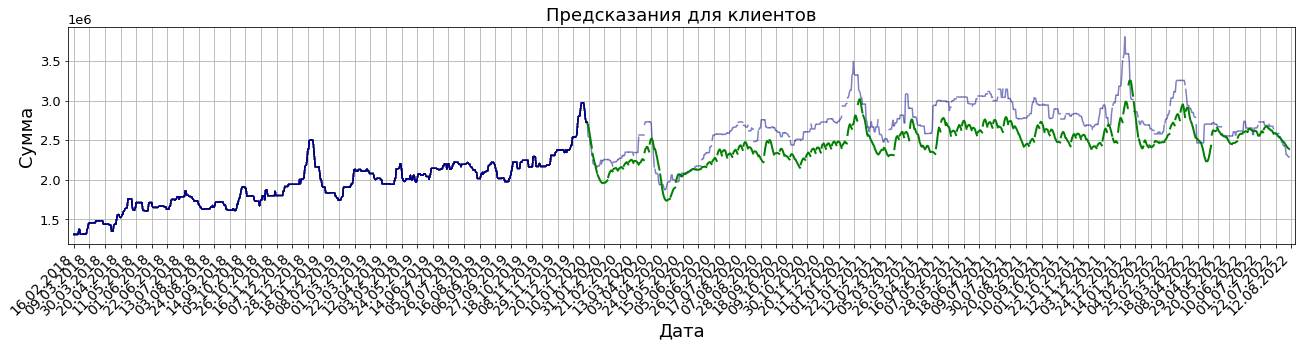

In [45]:
r = macro_help_functions.plot_clients_pred_base('all',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_all, next_full_fwd_true_all,split,
                                                dim, mem, fwd, days, 21,n_weeks)
plt.margins(x=0.005)

In [46]:
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_all)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_all)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%')

test MAPE median: 8.969%
test MAPE HP: 22.222%


### Class of clients with low predictability

In [47]:
nth_week = 0
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
scaler_bad, x_bad, y_bad, dat_bad = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], split, dim, mem)

model_bad, fwd_mapes_bad, full_fwd_pred_tr_bad, full_fwd_true_bad, \
                    y_pred_tr_bad, y_true_bad = macro_model_functions.make_model(scaler_bad, x_bad, y_bad, dat_bad, bad_rw.iloc[shift_days:],
                                                                                dim, mem, split, fwd, \
                                                                                n_epochs_each_model, n_batch_each_model,n_neurons_each_model,lr_each_model)

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

In [48]:
next_fwd_mapes_bad = fwd_mapes_bad.copy()
next_full_fwd_pred_tr_bad = full_fwd_pred_tr_bad.copy()
next_full_fwd_true_bad = full_fwd_true_bad.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    next_fwd_mapes_bad, next_full_fwd_pred_tr_bad, next_full_fwd_true_bad = macro_model_functions.make_pred_base_model(model_bad, next_scaler, next_dat, 
                            next_bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_bad, next_full_fwd_pred_tr_bad, next_full_fwd_true_bad)

  0%|          | 0/134 [00:00<?, ?it/s]

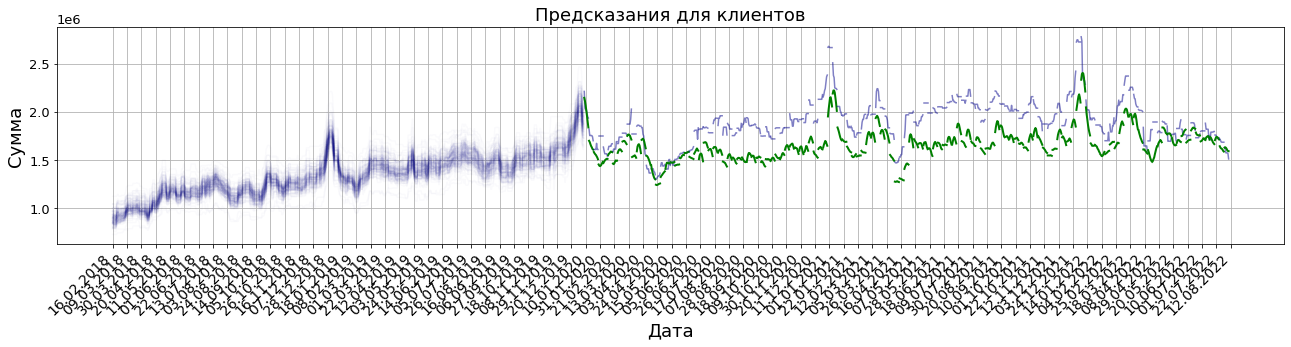

In [49]:
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_bad, next_full_fwd_true_bad,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [50]:
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad).shape[0]) * 100 :.3f}%')

test MAPE median: 13.324%
test MAPE HP: 17.778%


#### Finding clients in a given class once

In [51]:
nth_week = 52
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

scaler, x, y, dat = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], split, dim, mem)

model_bad, fwd_mapes_bad, full_fwd_pred_tr_bad, \
    full_fwd_true_bad, y_pred_tr_bad, y_true_bad = macro_model_functions.make_model(scaler, x, y, dat, bad_rw.iloc[shift_days:],
                                                                        dim, mem, split, fwd, \
                                                                        n_epochs_each_model, n_batch_each_model,
                                                                        n_neurons_each_model,lr_each_model)  

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

In [52]:
next_fwd_mapes_bad_1t = fwd_mapes_bad.copy()
next_full_fwd_pred_tr_bad_1t = full_fwd_pred_tr_bad.copy()
next_full_fwd_true_bad_1t = full_fwd_true_bad.copy()

for nth_week in trange(1,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    next_fwd_mapes_bad_1t, next_full_fwd_pred_tr_bad_1t, next_full_fwd_true_bad_1t = macro_model_functions.make_pred_base_model(model_bad, next_scaler, next_dat, 
                            bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_bad_1t, next_full_fwd_pred_tr_bad_1t, next_full_fwd_true_bad_1t)

  0%|          | 0/134 [00:00<?, ?it/s]

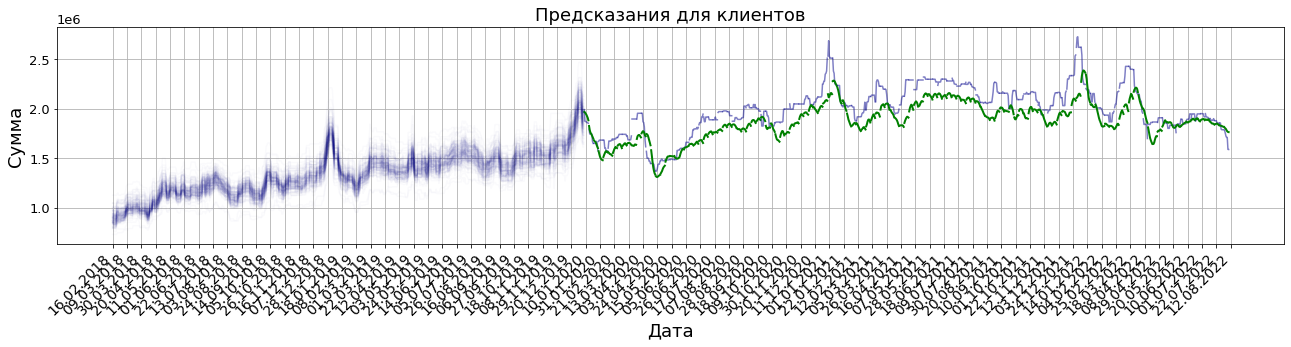

In [53]:
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_bad_1t, next_full_fwd_true_bad_1t,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [54]:
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad_1t)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad_1t).shape[0]) * 100 :.3f}%')

test MAPE median: 6.166%
test MAPE HP: 33.333%


### Plotting figures for what we have so far 

In [55]:
# MAPE for each client class
preds_each_week = pd.DataFrame({'good':next_fwd_mapes,'all': next_fwd_mapes_all, 'bad':next_fwd_mapes_bad})
preds_each_week.head()

,good,all,bad
0,0.039695,0.029752,0.026953
1,0.192107,0.022783,0.059465
2,0.060272,0.090548,0.042676
3,0.021689,0.125656,0.171129
4,0.040572,0.062015,0.049137


### The same experiment but with the incremental model

#### Class of clients with high predictability

In [58]:
lr_inc = 0.0001 # setting higher to adapt to changes faster
n_ep_inc = 10

In [59]:
tensorflow.keras.utils.set_random_seed(42)
in1 = Input(batch_shape = (1, mem, dim))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                    stateful=True, return_sequences=False, activation='relu')(in1)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(1, activation='linear')(out)

model_inc = Model(inputs=[in1], outputs=x)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
model_inc.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_inc.set_weights(model.get_weights())

In [60]:
inext_fwd_mapes = fwd_mapes.copy()
inext_full_fwd_pred_tr = full_fwd_pred_tr.copy()
inext_full_fwd_true = full_fwd_true.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_good_rw.iloc[shift_days:], next_split, dim, mem, 0)
    inext_fwd_mapes, inext_full_fwd_pred_tr, inext_full_fwd_true = macro_model_functions.use_inc_model(model_inc, next_scaler, next_dat, next_good_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes, inext_full_fwd_pred_tr, inext_full_fwd_true,n_ep_inc)

  0%|          | 0/134 [00:00<?, ?it/s]

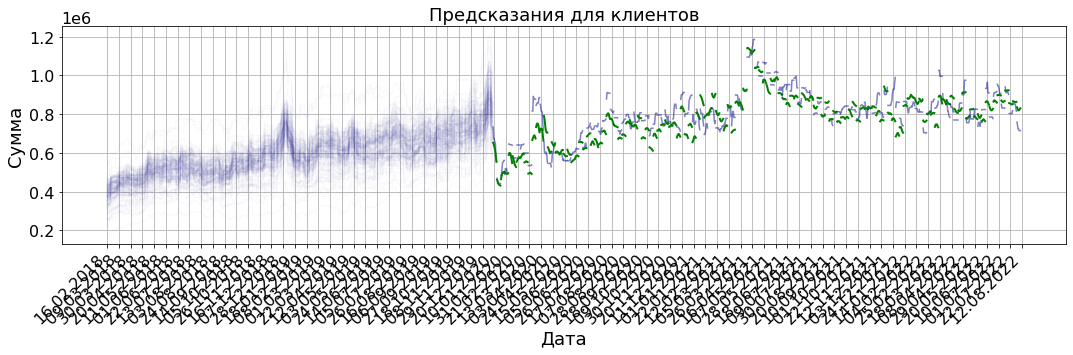

In [61]:
plt.rcParams['figure.figsize'] = 18, 4
r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr, inext_full_fwd_true,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [62]:
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes).shape[0]) * 100 :.3f}%')

test MAPE median: 5.180%
test MAPE HP: 48.148%


##### Finding clients in a given class once

In [63]:
nth_week = 52
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

inext_fwd_mapes_1t = fwd_mapes.copy()
inext_full_fwd_pred_tr_1t = full_fwd_pred_tr.copy()
inext_full_fwd_true_1t = full_fwd_true.copy()

for nth_week in trange(1,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], next_split, dim, mem, 0)
    inext_fwd_mapes_1t, inext_full_fwd_pred_tr_1t, inext_full_fwd_true_1t = macro_model_functions.use_inc_model(model_inc, next_scaler, next_dat, good_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes_1t, inext_full_fwd_pred_tr_1t, inext_full_fwd_true_1t,n_ep_inc)

  0%|          | 0/134 [00:00<?, ?it/s]

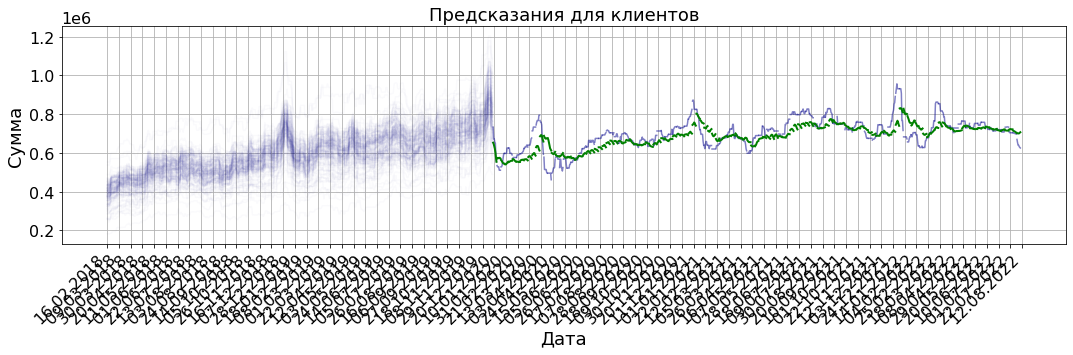

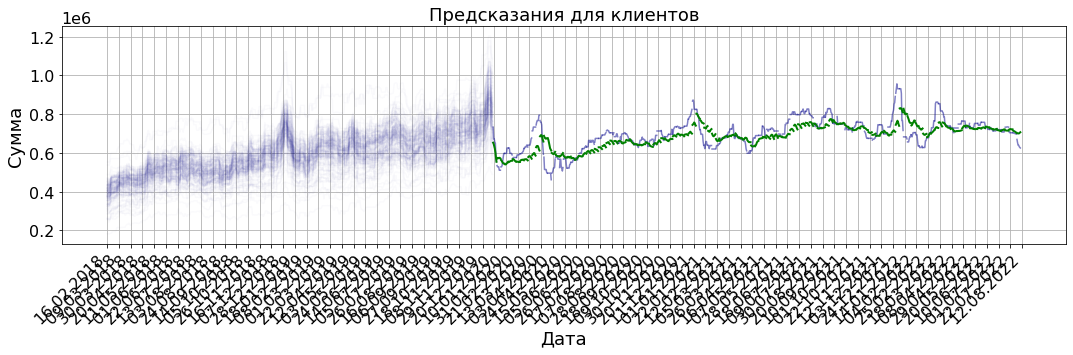

In [64]:
r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr_1t, inext_full_fwd_true_1t,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [65]:
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_1t)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_1t).shape[0]) * 100 :.3f}%')

test MAPE median: 4.714%
test MAPE HP: 54.815%


#### All clients

In [66]:
tensorflow.keras.utils.set_random_seed(42)
in1 = Input(batch_shape = (1, mem, dim))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                    stateful=True, return_sequences=False, activation='relu')(in1)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(1, activation='linear')(out)

model_all_inc = Model(inputs=[in1], outputs=x)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
model_all_inc.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_all_inc.set_weights(model_all.get_weights())

In [67]:
inext_fwd_mapes_all = fwd_mapes_all.copy()
inext_full_fwd_pred_tr_all = full_fwd_pred_tr_all.copy()
inext_full_fwd_true_all = full_fwd_true_all.copy()

good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

for nth_week in trange(1,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_all_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    inext_fwd_mapes_all, inext_full_fwd_pred_tr_all, inext_full_fwd_true_all = macro_model_functions.use_inc_model(model_all_inc, next_scaler, next_dat, next_all_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes_all, inext_full_fwd_pred_tr_all, inext_full_fwd_true_all,
                            n_ep_inc)

  0%|          | 0/134 [00:00<?, ?it/s]

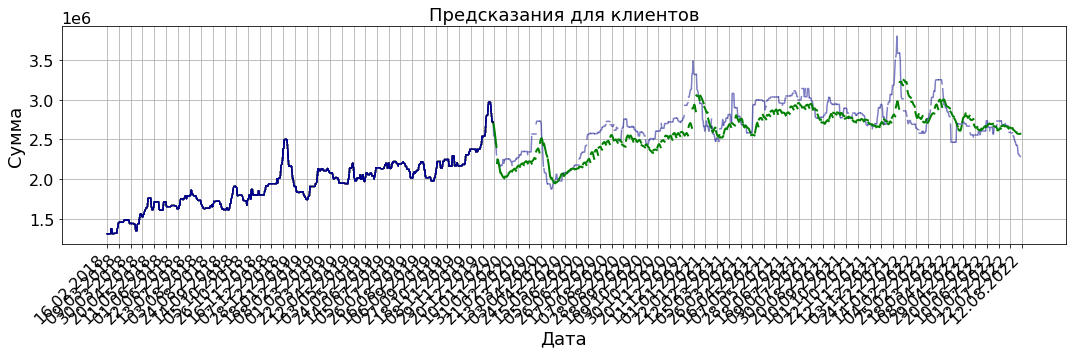

In [68]:
plt.rcParams['figure.figsize'] = 18, 4
r = macro_help_functions.plot_clients_pred_base('all',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr_all, inext_full_fwd_true_all,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [69]:
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_all)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%')

test MAPE median: 5.384%
test MAPE HP: 44.444%


#### Clients with low predictability

In [70]:
tensorflow.keras.utils.set_random_seed(42)
in1 = Input(batch_shape = (1, mem, dim))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                    stateful=True, return_sequences=False, activation='relu')(in1)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(1, activation='linear')(out)

model_bad_inc = Model(inputs=[in1], outputs=x)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
model_bad_inc.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_bad_inc.set_weights(model_bad.get_weights())

In [71]:
inext_fwd_mapes_bad = fwd_mapes_bad.copy()
inext_full_fwd_pred_tr_bad = full_fwd_pred_tr_bad.copy()
inext_full_fwd_true_bad = full_fwd_true_bad.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    inext_fwd_mapes_bad, inext_full_fwd_pred_tr_bad, inext_full_fwd_true_bad = macro_model_functions.use_inc_model(model_bad_inc, next_scaler, next_dat, next_bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes_bad, inext_full_fwd_pred_tr_bad, inext_full_fwd_true_bad,n_ep_inc)

  0%|          | 0/134 [00:00<?, ?it/s]

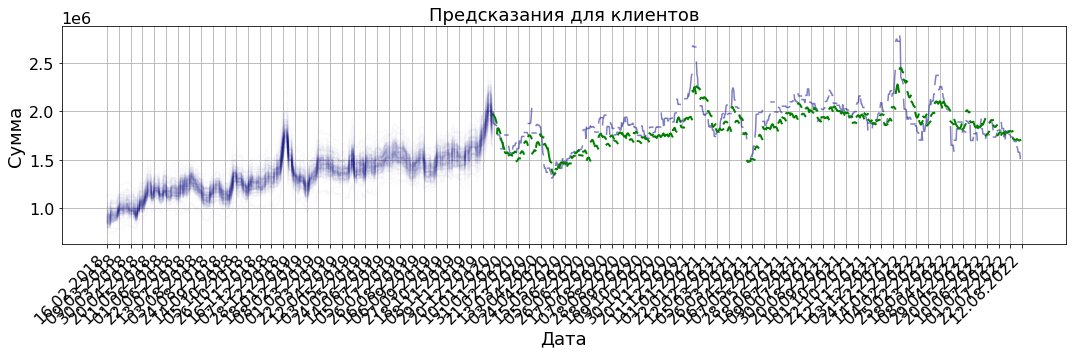

In [72]:
plt.rcParams['figure.figsize'] = 18, 4
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr_bad, inext_full_fwd_true_bad,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [73]:
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad).shape[0]) * 100 :.3f}%')

test MAPE median: 5.621%
test MAPE HP: 43.704%


##### Finding clients in a given class once

In [74]:
nth_week = 52
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

inext_fwd_mapes_bad_1t = fwd_mapes_bad.copy()
inext_full_fwd_pred_tr_bad_1t = full_fwd_pred_tr_bad.copy()
inext_full_fwd_true_bad_1t = full_fwd_true_bad.copy()

for nth_week in trange(1,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    inext_fwd_mapes_bad_1t, inext_full_fwd_pred_tr_bad_1t, \
    inext_full_fwd_true_bad_1t = macro_model_functions.use_inc_model(model_bad_inc, next_scaler, next_dat, bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd, inext_fwd_mapes_bad_1t, inext_full_fwd_pred_tr_bad_1t, inext_full_fwd_true_bad_1t,n_ep_inc)

  0%|          | 0/134 [00:00<?, ?it/s]

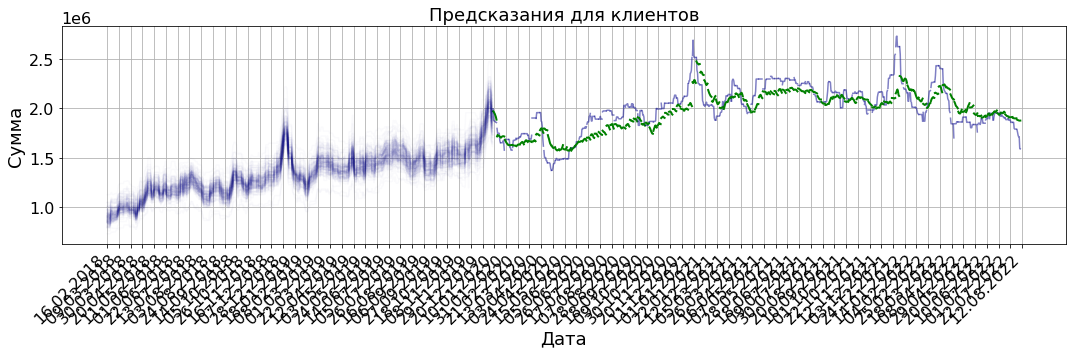

In [75]:
plt.rcParams['figure.figsize'] = 18, 4
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                 inext_full_fwd_pred_tr_bad_1t, inext_full_fwd_true_bad_1t,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks)

In [97]:
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad_1t)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad_1t).shape[0]) * 100 :.3f}%')

test MAPE median: 4.822%
test MAPE HP: 51.852%


### Final figures; 'quality for the same class'

Text(0, 0.5, 'MAPE')

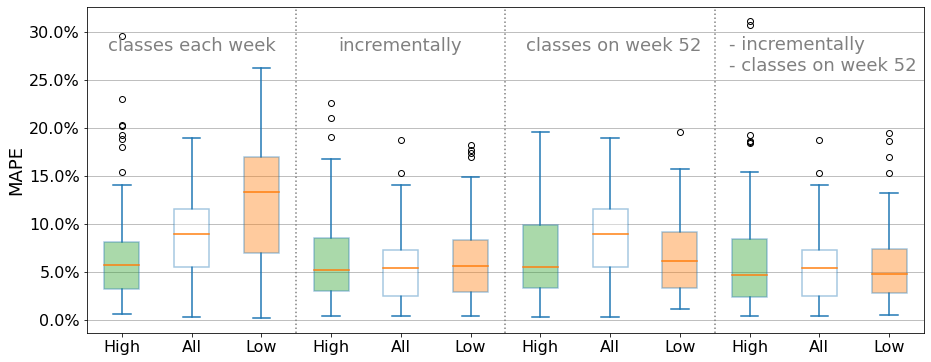

In [200]:
preds4_each_week = pd.DataFrame({'High pr.':next_fwd_mapes,'All': next_fwd_mapes_all,'Low pr.':next_fwd_mapes_bad,
                                 'High pr. (inc.)':inext_fwd_mapes,'All (inc.)': inext_fwd_mapes_all,'Low pr. (inc.)':inext_fwd_mapes_bad,
                                 'High pr. (1 time)':next_fwd_mapes_1t,'All2': next_fwd_mapes_all,'Low pr. (1 time)':next_fwd_mapes_bad_1t,
                                 'High pr. (inc., 1 time)':inext_fwd_mapes_1t,'All (inc.)2': inext_fwd_mapes_all,'Low pr. (inc., 1 time)':inext_fwd_mapes_bad_1t,
                                 })
plt.rcParams['figure.figsize'] = 15, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds4_each_week.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.text(0.8, 0.28, 'classes each week', color='gray')
plt.axvline(3.5, c='gray', ls=':')
plt.text(4.1, 0.28, 'incrementally', color='gray')
plt.axvline(6.5, c='gray', ls=':')
plt.text(6.8, 0.28, 'classes on week 52', color='gray')
plt.axvline(9.5, c='gray', ls=':')
plt.text(9.7, 0.26, '- incrementally\n- classes on week 52', color='gray')

colors = [cmap.colors[2],'white',cmap.colors[1],
         cmap.colors[2],'white',cmap.colors[1],
         cmap.colors[2],'white',cmap.colors[1],
         cmap.colors[2],'white',cmap.colors[1]
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,13), ['High','All','Low']*4, rotation=0, ha='center')
plt.grid(axis='y')
plt.ylabel('MAPE')

## Forecasting; forecast quality for all clients based on a given class

In [78]:
mape_good_pred_vs_all = []
imape_good_pred_vs_all = []
mape_bad_pred_vs_all = []
imape_bad_pred_vs_all = []

for nth_week in trange(0,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    # MAPE: forecasts for clients with high predictability multiplied by a coefficient VS real values for all clients
    coeff = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    mape_good_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                next_full_fwd_pred_tr[nth_week]*coeff))
    # MAPE: incremental model
    imape_good_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                inext_full_fwd_pred_tr[nth_week]*coeff))
    # MAPE: forecasts for clients with low predictability -//-
    coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    mape_bad_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   next_full_fwd_pred_tr_bad[nth_week]*coeff_bad))
    # MAPE: incremental model
    imape_bad_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   inext_full_fwd_pred_tr_bad[nth_week]*coeff_bad))

  0%|          | 0/135 [00:00<?, ?it/s]

In [79]:
mape_good_pred_vs_all_1t = []
imape_good_pred_vs_all_1t = []
mape_bad_pred_vs_all_1t = []
imape_bad_pred_vs_all_1t = []

# MAPE for experiment cases, when class clients were chosen once on week 52
good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,52,window_size=21)
for nth_week in trange(0,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    coeff = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))

    mape_good_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                next_full_fwd_pred_tr_1t[nth_week]*coeff))
    imape_good_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                inext_full_fwd_pred_tr_1t[nth_week]*coeff))

    coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))

    mape_bad_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   next_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad))
    imape_bad_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   inext_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad))

  0%|          | 0/135 [00:00<?, ?it/s]

Predictions for when clients were found each week and without incremental learning

  0%|          | 0/135 [00:00<?, ?it/s]

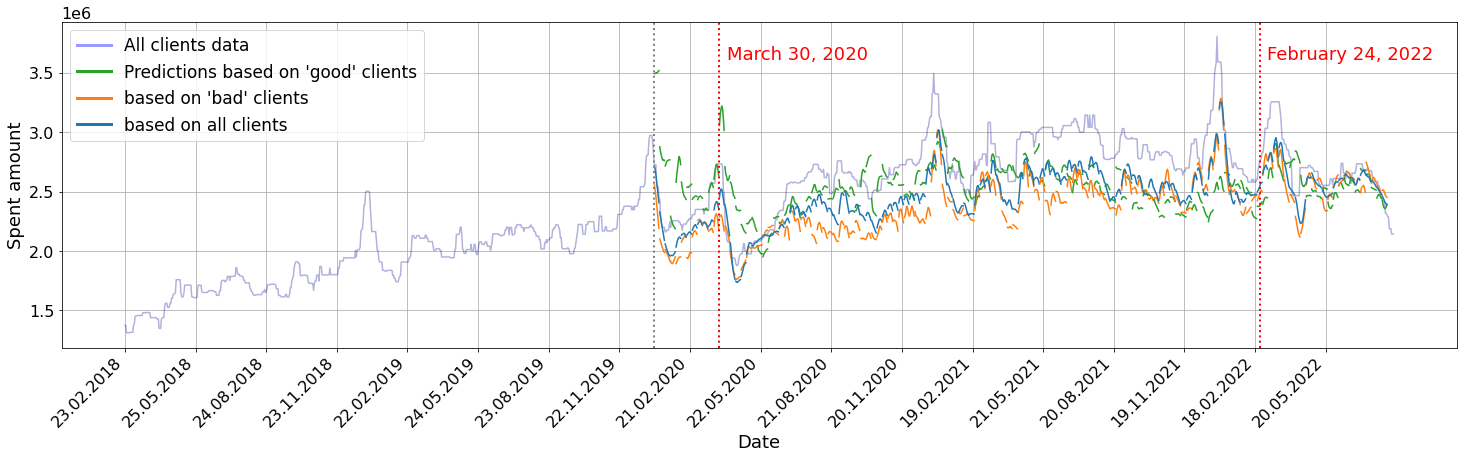

In [80]:
plt.rcParams['figure.figsize'] = 25, 6
ytt = all_rw[shift_days+mem+dim:].values.reshape(-1)
plt.plot(ytt, c='darkblue', alpha=.3, label='All clients data')

for nth_week in trange(0,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    x_coords = np.arange(len(ytt)-next_split-2,len(ytt)-next_split-2+fwd)
    
    coeff = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    plt.plot(x_coords, next_full_fwd_pred_tr[nth_week]*coeff,'-',c=cmap.colors[2])
    #plt.plot(x_coords, next_full_fwd_pred_tr[nth_week],'r-')
    
    coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    plt.plot(x_coords, next_full_fwd_pred_tr_bad[nth_week]*coeff_bad, color=cmap.colors[1],linestyle='-')
    #plt.plot(x_coords, next_full_fwd_pred_tr_bad[nth_week],'b-')
    
    plt.plot(x_coords, next_full_fwd_pred_tr_all[nth_week],'-', c=cmap.colors[0])
    
ticks=days[shift_days+mem+dim:]
xt=np.arange(0, len(ticks), 13)
plt.xticks(xt[::7], ticks.iloc[xt][::7], rotation=45, ha='right')

lines = [Line2D([0], [0], color='blue', linewidth=3, linestyle='-', alpha=0.4),
        Line2D([0], [0], color=cmap.colors[2], linewidth=3, linestyle='-'),
        Line2D([0], [0], color=cmap.colors[1], linewidth=3, linestyle='-'),
        Line2D([0], [0], color=cmap.colors[0], linewidth=3, linestyle='-')]
labels = ['All clients data',"Predictions based on 'good' clients", "based on 'bad' clients", 'based on all clients']
plt.legend(lines, labels)

plt.axvline(len(ytt)-split-2,ls=':',c='gray',lw=2)

plt.axvline(766,ls=':',c='red',lw=2)
plt.text(776, ytt.max()*0.95,'March 30, 2020',c='red')

plt.axvline(1462,ls=':',c='red',lw=2)
plt.text(1472, ytt.max()*0.95,'February 24, 2022',c='red',)

plt.grid()
plt.ylabel('Spent amount')
plt.xlabel('Date');

Predictions for when class clients were found once and without incremental learning

  0%|          | 0/135 [00:00<?, ?it/s]

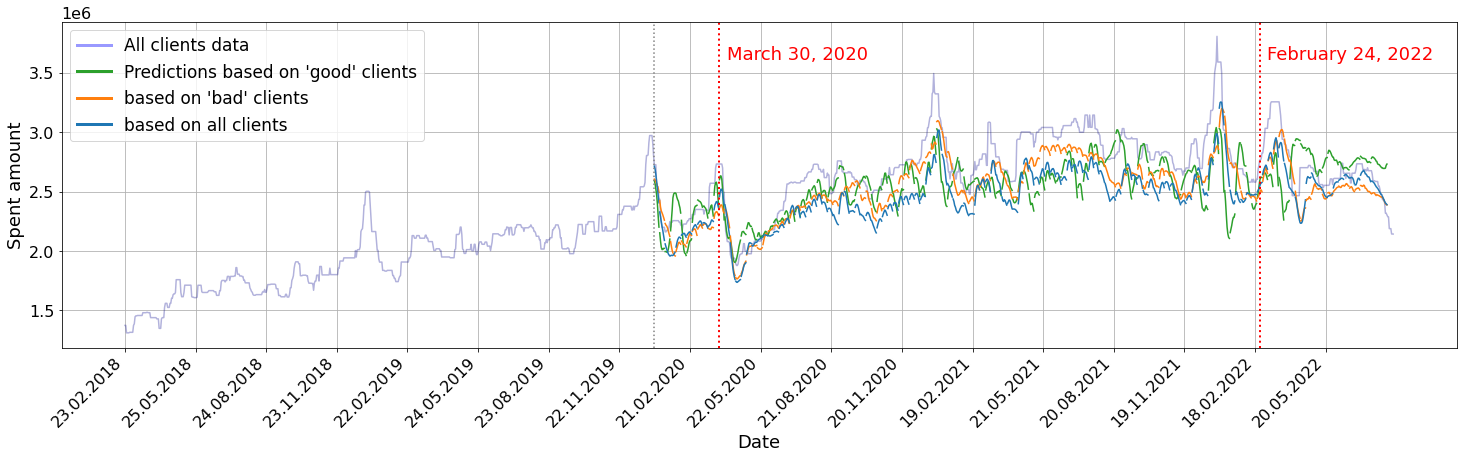

In [81]:
plt.rcParams['figure.figsize'] = 25, 6
ytt = all_rw[shift_days+mem+dim:].values.reshape(-1)
plt.plot(ytt, c='darkblue', alpha=.3, label='Реальные данные всех клиентов')
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week=52,window_size=21)

for nth_week in trange(0,n_weeks-1):
    
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    x_coords = np.arange(len(ytt)-next_split-2,len(ytt)-next_split-2+fwd)
    
    coeff = np.median(all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    plt.plot(x_coords, next_full_fwd_pred_tr_1t[nth_week]*coeff,'-',c=cmap.colors[2])
    #plt.plot(x_coords, next_full_fwd_pred_tr[nth_week],'r-')
    
    coeff_bad = np.median(all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    plt.plot(x_coords, next_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad, color=cmap.colors[1],linestyle='-')
    #plt.plot(x_coords, next_full_fwd_pred_tr_bad[nth_week],'b-')
    
    plt.plot(x_coords, next_full_fwd_pred_tr_all[nth_week],'-', c=cmap.colors[0])
    
ticks=days[shift_days+mem+dim:]
xt=np.arange(0, len(ticks), 13)
plt.xticks(xt[::7], ticks.iloc[xt][::7], rotation=45, ha='right')

plt.axvline(766,ls=':',c='red',lw=2)
plt.text(776, ytt.max()*0.95,'March 30, 2020',c='red')

plt.axvline(1462,ls=':',c='red',lw=2)
plt.text(1472, ytt.max()*0.95,'February 24, 2022',c='red',)

lines = [Line2D([0], [0], color='blue', linewidth=3, linestyle='-', alpha=0.4),
        Line2D([0], [0], color=cmap.colors[2], linewidth=3, linestyle='-'),
        Line2D([0], [0], color=cmap.colors[1], linewidth=3, linestyle='-'),
        Line2D([0], [0], color=cmap.colors[0], linewidth=3, linestyle='-')]
labels = ['All clients data',"Predictions based on 'good' clients", "based on 'bad' clients", 'based on all clients']
plt.legend(lines, labels)

plt.axvline(len(ytt)-split-2,ls=':',c='gray')
plt.grid()
plt.ylabel('Spent amount')
plt.xlabel('Date');

In [82]:
# MAPE values for finding class clients every week
temp_vs_all = pd.DataFrame({'good':mape_good_pred_vs_all,'igood':imape_good_pred_vs_all,'all': next_fwd_mapes_all, 'iall': inext_fwd_mapes_all,
                            'bad':mape_bad_pred_vs_all,'ibad':imape_bad_pred_vs_all})
temp_vs_all.head()

,good,igood,all,iall,bad,ibad
0,0.400904,0.581810,0.029752,0.029752,0.047591,0.080033
1,0.275015,0.062839,0.022783,0.019428,0.070900,0.020672
2,0.249736,0.092034,0.090548,0.073047,0.105889,0.042334
3,0.017576,0.048039,0.125656,0.096158,0.150318,0.083190
4,0.216089,0.149743,0.062015,0.061640,0.133847,0.106341


In [83]:
# MAPE values for finding class clients once
temp_vs_all_1t = pd.DataFrame({'good':mape_good_pred_vs_all_1t,'igood':imape_good_pred_vs_all_1t,
                            'all': next_fwd_mapes_all, 'iall': inext_fwd_mapes_all,
                            'bad':mape_bad_pred_vs_all_1t,'ibad':imape_bad_pred_vs_all_1t})
temp_vs_all_1t.head()

,good,igood,all,iall,bad,ibad
0,0.030563,0.030563,0.029752,0.029752,0.036227,0.036227
1,0.066929,0.040194,0.022783,0.019428,0.060357,0.039371
2,0.082589,0.023148,0.090548,0.073047,0.025447,0.031025
3,0.066012,0.047711,0.125656,0.096158,0.112370,0.030203
4,0.080320,0.022053,0.062015,0.061640,0.081966,0.037971


Difference between forecasts based on clients with high predictability and the once with low predictabiity

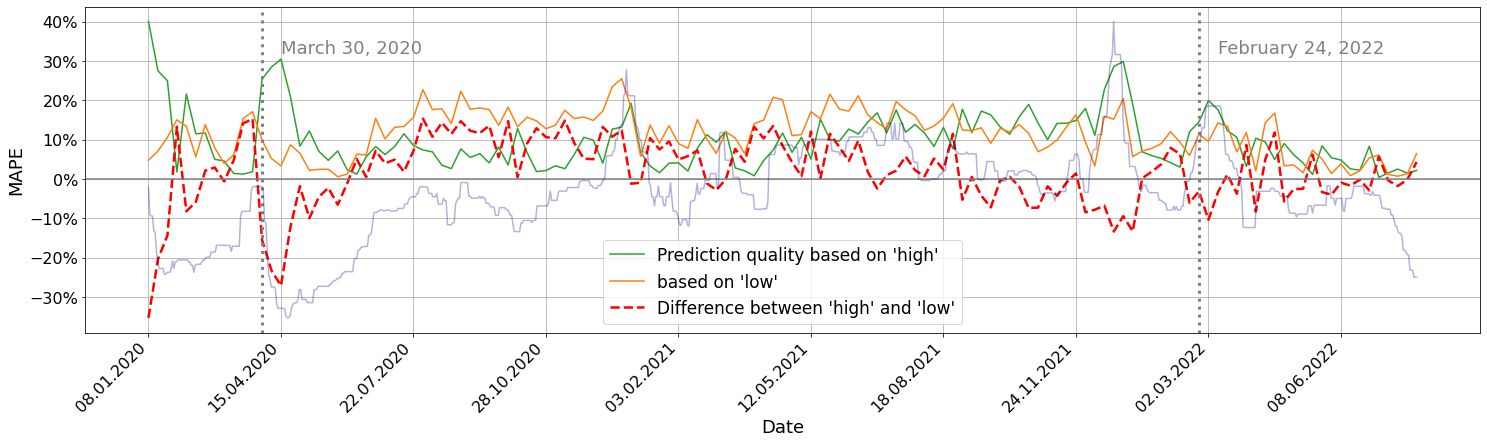

In [237]:
plt.rcParams['figure.figsize'] = 25, 6

fig=plt.figure()

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax2.plot(days[-split:],ytt[-split:], c='darkblue', alpha=.3, label="All clients' data")
ax2.axis('off')

ax.plot(temp_vs_all['good'],'-',c=cmap.colors[2],label="Prediction quality based on 'high'")
#ax.plot(temp_vs_all['all'],'-',label='based on all clients', c=cmap.colors[0])
ax.plot(temp_vs_all['bad'],'-',label="based on 'low'",c=cmap.colors[1])
ax.plot((temp_vs_all['bad']-temp_vs_all['good']),'--',label="Difference between 'high' and 'low'",c='red',lw=2.5)

ax.set_xticks(np.arange(0, len(a0_dm[1:]),14))
ax.set_xticklabels(a0_dm[1::14],rotation=45, ha='right')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(0.,c='gray',ls='-')

ax.grid()
ax.legend()

ax.axvline(12,ls=':',c='gray',lw=3)
ax.text(14,0.32,'March 30, 2020',c='gray')
ax.axvline(111,ls=':',c='gray',lw=3)
ax.text(113,0.32,'February 24, 2022',c='gray')

#plt.title('Ошибки предсказаний относительно реальных данных всех клиентов')
ax.set_ylabel('MAPE')
ax.set_xlabel('Date');


Median and HP for first experiment case

In [89]:
mape_hp = 0.05

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(next_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(next_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(mape_good_pred_vs_all)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(mape_bad_pred_vs_all).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 8.969%
ALL vs ALL preds: test MAPE HP (<=5.0%): 22.222%

GOOD vs ALL preds: test MAPE median: 8.337%
GOOD vs ALL preds: test MAPE HP (<=5.0%): 30.370%

BAD vs ALL preds: test MAPE median: 12.387%
BAD vs ALL preds: test MAPE HP (<=5.0%): 14.815%


Median and HP for third experiment case

In [91]:
mape_hp = 0.05

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(next_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(next_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(mape_good_pred_vs_all_1t)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all_1t).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all_1t)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(mape_bad_pred_vs_all_1t).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 8.969%
ALL vs ALL preds: test MAPE HP (<=5.0%): 22.222%

GOOD vs ALL preds: test MAPE median: 6.651%
GOOD vs ALL preds: test MAPE HP (<=5.0%): 38.519%

BAD vs ALL preds: test MAPE median: 6.353%
BAD vs ALL preds: test MAPE HP (<=5.0%): 37.037%


In [ ]:
mape_good_pred_vs_all_1t = []
imape_good_pred_vs_all_1t = []
mape_bad_pred_vs_all_1t = []
imape_bad_pred_vs_all_1t = []

good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,52,window_size=21)
for nth_week in trange(0,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    # Считаем MAPE для предсказаний хороших клиентов, умноженных на коэфф.
    coeff = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))

    mape_good_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                next_full_fwd_pred_tr_1t[nth_week]*coeff))
    imape_good_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                inext_full_fwd_pred_tr_1t[nth_week]*coeff))
    # Считаем MAPE для предсказаний плохих клиентов, умноженных на коэфф.
    coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))

    mape_bad_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   next_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad))
    imape_bad_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   inext_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad))

Median and HP for fourth experiment case

In [219]:
mape_hp = 0.05

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(inext_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(imape_good_pred_vs_all_1t)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_good_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(imape_good_pred_vs_all_1t).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(imape_bad_pred_vs_all_1t)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_bad_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(imape_bad_pred_vs_all_1t).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 5.384%
ALL vs ALL preds: test MAPE HP (<=5.0%): 44.444%

GOOD vs ALL preds: test MAPE median: 4.952%
GOOD vs ALL preds: test MAPE HP (<=5.0%): 50.370%

BAD vs ALL preds: test MAPE median: 4.441%
BAD vs ALL preds: test MAPE HP (<=5.0%): 54.815%


Median and HP for second experiment case

In [238]:
mape_hp = 0.05

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(inext_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(imape_good_pred_vs_all)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_good_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(imape_good_pred_vs_all).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(imape_bad_pred_vs_all)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_bad_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(imape_bad_pred_vs_all).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 5.384%
ALL vs ALL preds: test MAPE HP (<=5.0%): 44.444%

GOOD vs ALL preds: test MAPE median: 6.211%
GOOD vs ALL preds: test MAPE HP (<=5.0%): 37.037%

BAD vs ALL preds: test MAPE median: 5.674%
BAD vs ALL preds: test MAPE HP (<=5.0%): 45.926%


### Final figures; 'quality based on different classes'

some outliers are not visible after limiting by Y 

In [ ]:
temp_vs_all = pd.DataFrame({'good':mape_good_pred_vs_all,'igood':imape_good_pred_vs_all,'all': next_fwd_mapes_all, 'iall': inext_fwd_mapes_all,
                            'bad':mape_bad_pred_vs_all,'ibad':imape_bad_pred_vs_all})

Text(0, 0.5, 'MAPE')

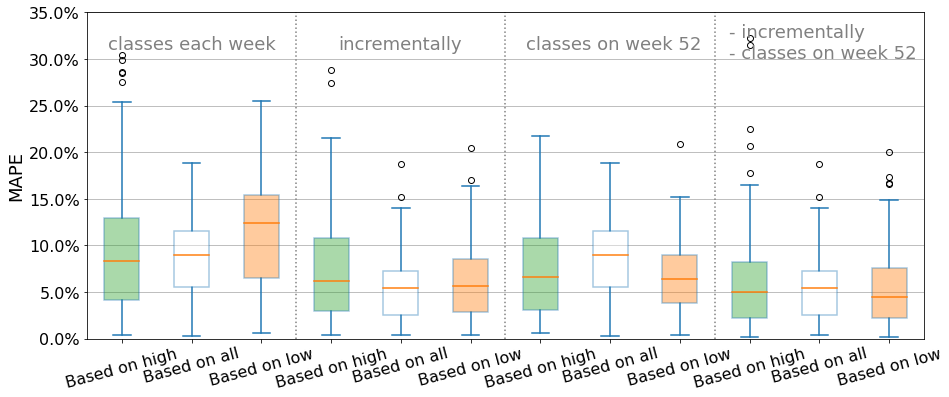

In [232]:
preds4_each_week = pd.DataFrame({'High pr.':mape_good_pred_vs_all,'All': next_fwd_mapes_all,'Low pr.':mape_bad_pred_vs_all,
                                 'High pr. (inc.)':imape_good_pred_vs_all,'All (inc.)': inext_fwd_mapes_all,'Low pr. (inc.)':imape_bad_pred_vs_all,
                                 'High pr. (1 time)':mape_good_pred_vs_all_1t,'All2': next_fwd_mapes_all,'Low pr. (1 time)':mape_bad_pred_vs_all_1t,
                                 'High pr. (inc., 1 time)':imape_good_pred_vs_all_1t,'All (inc.)2': inext_fwd_mapes_all,'Low pr. (inc., 1 time)':imape_bad_pred_vs_all_1t,
                                 })
plt.rcParams['figure.figsize'] = 15, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds4_each_week.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
hei = 0.31
plt.text(0.8, hei, 'classes each week', color='gray')
plt.axvline(3.5, c='gray', ls=':')
plt.text(4.1, hei, 'incrementally', color='gray')
plt.axvline(6.5, c='gray', ls=':')
plt.text(6.8, hei, 'classes on week 52', color='gray')
plt.axvline(9.5, c='gray', ls=':')
plt.text(9.7, hei*0.97, '- incrementally\n- classes on week 52', color='gray')

colors = [cmap.colors[2],'white',cmap.colors[1],
         cmap.colors[2],'white',cmap.colors[1],
         cmap.colors[2],'white',cmap.colors[1],
         cmap.colors[2],'white',cmap.colors[1]
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,13), ['Based on high','Based on all','Based on low']*4, rotation=15, ha='center')
plt.grid(axis='y')
plt.ylim(0,0.35)
plt.ylabel('MAPE')
